# Recipe NLP: Results Visualization and Analysis

This notebook visualizes the results generated by the main pipeline (`src/main.py`). It loads the saved artifacts and creates plots for EDA, text analysis, network communities, clustering/topic modeling outputs, stability, and outliers.

## 0. Setup: Import Libraries and Load Configuration

In [3]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
import umap # Need umap-learn installed
from collections import Counter
import os
import sys
import pickle # To load saved results
import warnings

# Suppress specific warnings if needed
# warnings.filterwarnings("ignore", category=UserWarning, module='umap')
# warnings.filterwarnings("ignore", category=UserWarning, module='joblib')
# warnings.filterwarnings("ignore", category=FutureWarning)

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style='whitegrid')
sns.set_context("notebook", font_scale=1.1)
%matplotlib inline

In [2]:
# --- Setup Project Path ---
# Add the project root directory to the Python path to import 'src' modules
try:
    # Assumes notebook is in 'notebooks' folder, root is one level up
    notebook_dir = os.path.abspath(os.getcwd())
    project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
    if 'notebooks' not in notebook_dir.lower(): # Handle if running from root
        project_root = notebook_dir

    if project_root not in sys.path:
        sys.path.insert(0, project_root)
        print(f"Added '{project_root}' to sys.path")
    else:
        print(f"'{project_root}' already in sys.path")

    # --- Import Configuration and Utils ---
    from src.config import (
        RESULTS_DIR, PROCESSED_DF_FILE, ALL_RESULTS_FILE, INGREDIENT_EMB_FILE,
        NETWORK_RESULTS_FILE,
        TITLE_COLUMN, INGREDIENTS_LIST_COLUMN, DIRECTIONS_LIST_COLUMN,
        CLUSTER_TEXT_COLUMN_SPACY, CLUSTER_TEXT_COLUMN_SPACY_STR, TOPIC_TEXT_COLUMN_SPACY,
        INGREDIENTS_RAW_JOINED_COL, DIRECTIONS_RAW_JOINED_COL,
        LDA_TRAD_COHERENCE_MEASURE, RANDOM_STATE
    )
    from src.utils import find_best_config
    # Import analysis functions needed to regenerate labels/embeddings for visualization
    from src.clustering import (
        vectorize_text_tfidf, reduce_dimensions_svd, reduce_dimensions_umap,
        perform_kmeans, get_top_terms_per_cluster, get_representative_texts
    )
    from src.topic_modeling import (
        vectorize_text_count, perform_lda, get_top_words_per_topic
    )

    print(f"Successfully imported config and utils.")
    CONFIG_LOADED = True

except ImportError as e:
    print(f"Error importing from 'src': {e}. Ensure correct project structure and __init__.py files.")
    print(f"Attempted project root: {project_root}")
    print("Proceeding without config/utils. Functionality will be limited.")
    CONFIG_LOADED = False
    # Define placeholders if config failed
    RESULTS_DIR = 'results'
    PROCESSED_DF_FILE = os.path.join(RESULTS_DIR, 'processed_recipes.pkl')
    ALL_RESULTS_FILE = os.path.join(RESULTS_DIR, 'all_analysis_results.pkl')
    INGREDIENT_EMB_FILE = os.path.join(RESULTS_DIR, 'ingredient_embeddings.npy')
    NETWORK_RESULTS_FILE = os.path.join(RESULTS_DIR, 'network_analysis_results.pkl')
    RANDOM_STATE = 42
    # Add other necessary placeholders
    TITLE_COLUMN='title'
    INGREDIENTS_RAW_JOINED_COL = 'ingredients_raw_str'
    DIRECTIONS_RAW_JOINED_COL = 'directions_raw_str'
    CLUSTER_TEXT_COLUMN_SPACY_STR = 'directions_spacy_str' # Example
    LDA_TRAD_COHERENCE_MEASURE = 'c_v' # Example
    def find_best_config(*args, **kwargs): return None # Dummy function

# --- Visualization Configuration ---
VIS_N_COMPONENTS_UMAP = 2
VIS_UMAP_N_NEIGHBORS = 15
VIS_UMAP_MIN_DIST = 0.1
VIS_UMAP_METRIC = 'cosine'

Added 'e:\Documents\NLP\Final Project' to sys.path
Successfully imported config and utils.


## 1. Load Saved Results and Data

In [4]:
# --- Construct Absolute Paths ---
# Use project_root determined earlier
results_abs_dir = os.path.join(project_root, RESULTS_DIR)
df_analysis_path = os.path.join(results_abs_dir, os.path.basename(PROCESSED_DF_FILE))
all_results_path = os.path.join(results_abs_dir, os.path.basename(ALL_RESULTS_FILE))
embeddings_path = os.path.join(results_abs_dir, os.path.basename(INGREDIENT_EMB_FILE))
network_path = os.path.join(results_abs_dir, os.path.basename(NETWORK_RESULTS_FILE))

print(f"--- Loading Data from '{results_abs_dir}' ---")

# --- Load Processed DataFrame ---
df_analysis = None
print(f"Attempting to load processed DataFrame from: {df_analysis_path}")
try:
    df_analysis = pd.read_pickle(df_analysis_path)
    print(f"Processed DataFrame loaded successfully. Shape: {df_analysis.shape}")
    # print("\nDataFrame Info:")
    df_analysis.info()
except FileNotFoundError:
    print(f"Error: Processed DataFrame file not found at '{df_analysis_path}'. Run the main pipeline script (src/main.py) first.")
except Exception as e:
    print(f"An error occurred loading the DataFrame pickle file: {e}")

# --- Load All Analysis Results ---
all_results = None
print(f"\nAttempting to load all analysis results from: {all_results_path}")
try:
    with open(all_results_path, 'rb') as f:
        all_results = pickle.load(f)
    print(f"Analysis results loaded successfully. Keys: {list(all_results.keys())}")
except FileNotFoundError:
    print(f"Error: Analysis results file not found at '{all_results_path}'. Run the main pipeline first.")
    all_results = {} # Initialize empty to prevent downstream errors
except Exception as e:
    print(f"An error occurred loading the analysis results pickle file: {e}")
    all_results = {}

# --- Load Ingredient Embeddings ---
ingredient_embeddings = None
print(f"\nAttempting to load ingredient embeddings from: {embeddings_path}")
try:
    ingredient_embeddings = np.load(embeddings_path)
    print(f"Ingredient embeddings loaded successfully (Shape: {ingredient_embeddings.shape})")
    # Verify shape consistency if df_analysis loaded
    if df_analysis is not None and ingredient_embeddings.shape[0] != len(df_analysis):
        print(f"Warning: Embedding length ({ingredient_embeddings.shape[0]}) != DataFrame length ({len(df_analysis)}). Mismatch possible.")
        # Consider trimming or erroring based on use case. For viz, usually proceed with caution.
except FileNotFoundError:
    print(f"Warning: Ingredient embeddings file not found at '{embeddings_path}'. Embedding visualizations will be skipped.")
except Exception as e:
    print(f"An error occurred loading the ingredient embeddings file: {e}")

# --- Load Network Analysis Results ---
network_results = None
print(f"\nAttempting to load network analysis results from: {network_path}")
try:
    with open(network_path, 'rb') as f:
        network_results = pickle.load(f)
    print(f"Network results loaded successfully. Keys: {list(network_results.keys())}")
    if 'graph_summary' in network_results:
         print("Network Summary:", network_results['graph_summary'])
    if 'partition' in network_results:
         print(f"Network partition loaded ({len(network_results['partition'])} nodes).")
except FileNotFoundError:
    print(f"Warning: Network results file not found at '{network_path}'. Network visualizations might be skipped.")
except Exception as e:
    print(f"An error occurred loading the network results pickle file: {e}")

--- Loading Data from 'e:\Documents\NLP\Final Project\results' ---
Attempting to load processed DataFrame from: e:\Documents\NLP\Final Project\results\processed_recipes_sample_with_text.pkl
Processed DataFrame loaded successfully. Shape: (50000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   title                            50000 non-null  object
 1   ingredients                      50000 non-null  object
 2   directions                       50000 non-null  object
 3   link                             50000 non-null  object
 4   source                           50000 non-null  object
 5   NER                              50000 non-null  object
 6   ingredients_joined_raw           50000 non-null  object
 7   directions_joined_raw            50000 non-null  object
 8   num_ingredients           

## 2. Basic Distributions and EDA


--- 2. Basic EDA Visualizations ---


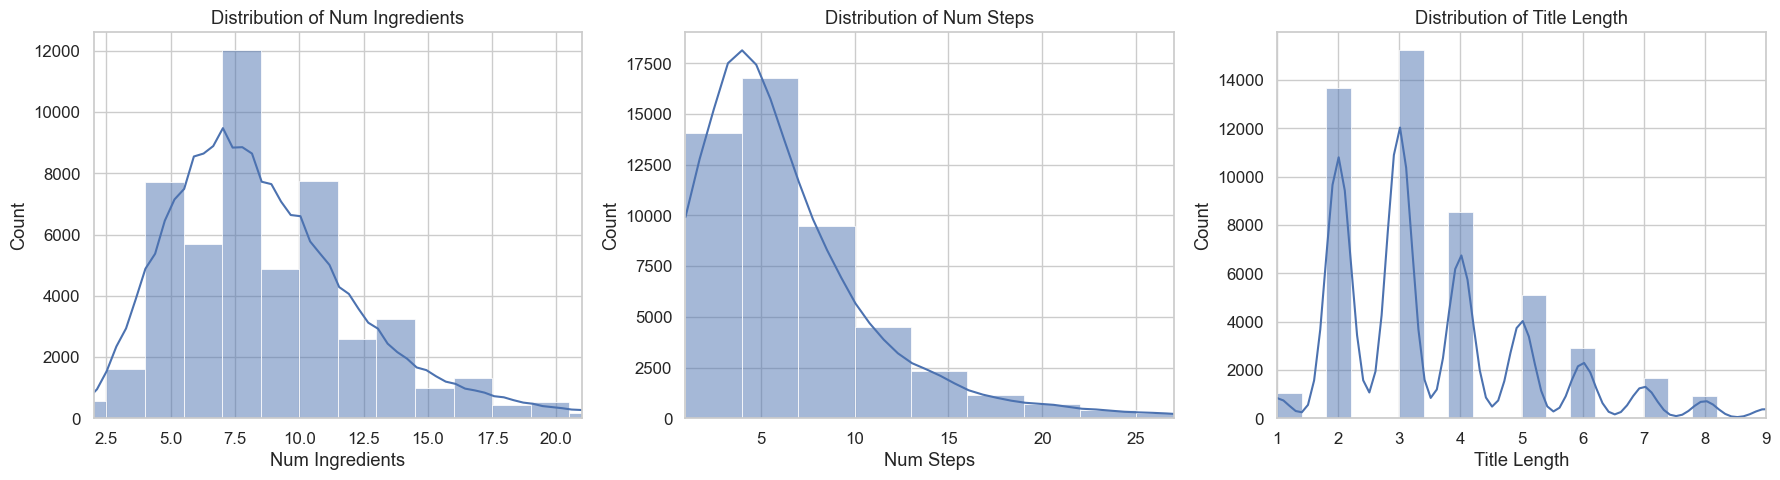

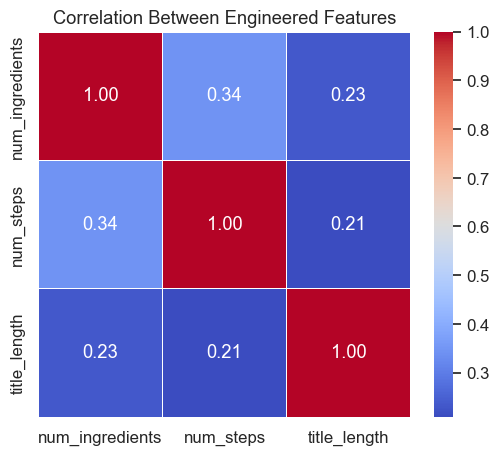

In [5]:
if df_analysis is not None:
    print("\n--- 2. Basic EDA Visualizations ---")
    # Identify available engineered feature columns
    eda_cols = ['num_ingredients', 'num_steps', 'title_length']
    existing_eda_cols = [col for col in eda_cols if col in df_analysis.columns]

    if existing_eda_cols:
        # Distribution Plots
        num_features = len(existing_eda_cols)
        plt.figure(figsize=(6 * num_features, 5))
        for i, feature in enumerate(existing_eda_cols):
            plt.subplot(1, num_features, i + 1)
            valid_data = df_analysis[feature].dropna()
            if not valid_data.empty:
                q01 = valid_data.quantile(0.01)
                q99 = valid_data.quantile(0.99)
                if q99 <= q01 : q99 = valid_data.max()
                if np.isnan(q99): q99 = None

                sns.histplot(valid_data, bins=50, kde=True)
                plt.title(f'Distribution of {feature.replace("_", " ").title()}')
                plt.xlabel(feature.replace("_", " ").title())
                if q99 is not None:
                    plt.xlim(max(0, q01), q99)
            else:
                plt.title(f'{feature.replace("_", " ").title()} (No Data)')

        plt.tight_layout()
        plt.show()

        # Correlation Matrix
        if len(existing_eda_cols) >= 2:
            corr_matrix = df_analysis[existing_eda_cols].corr()
            plt.figure(figsize=(6, 5))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
            plt.title('Correlation Between Engineered Features')
            plt.show()
        else:
            print("Need at least two engineered feature columns for correlation matrix.")
    else:
        print("No engineered feature columns ('num_ingredients', 'num_steps', 'title_length') found in DataFrame.")
else:
    print("DataFrame not loaded. Skipping EDA plots.")

## 3. Text Analysis: Word Clouds


--- 3. Text Analysis Word Clouds ---
Generating Word Cloud for Recipe Titles...


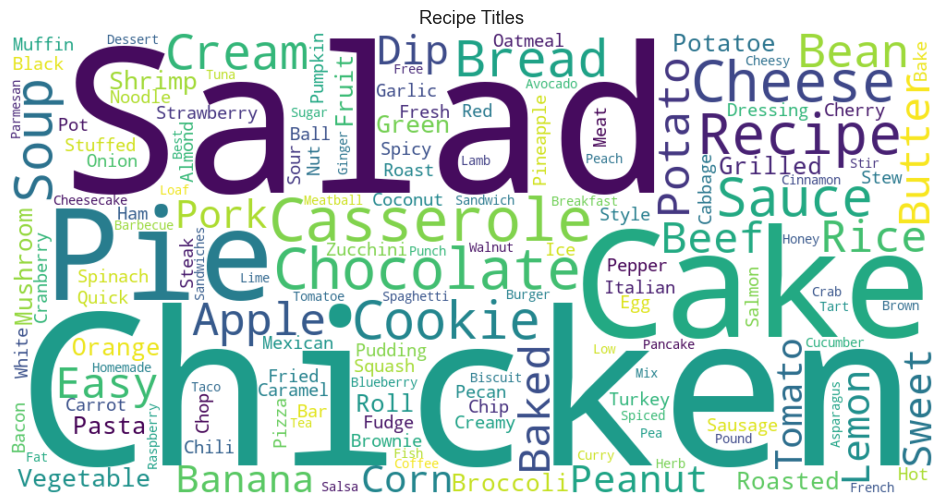

Generating Word Cloud for Raw Ingredients...


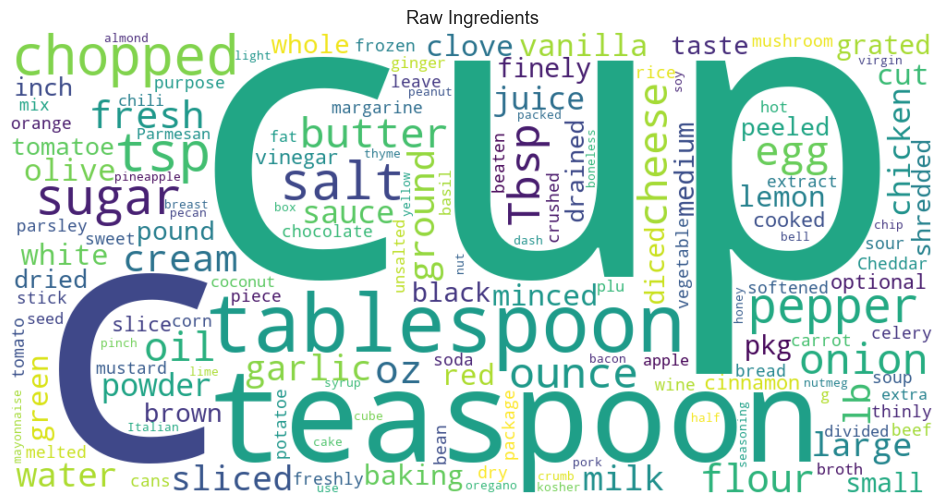

Generating Word Cloud for Raw Directions...


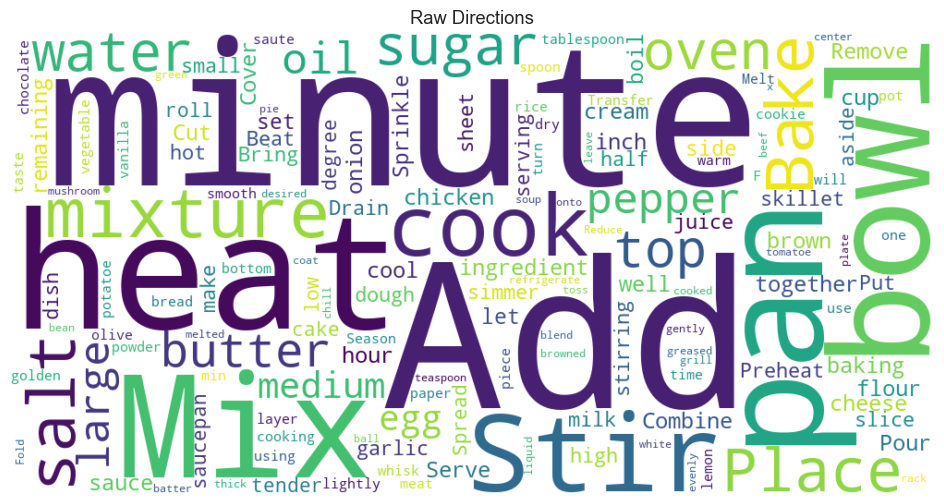

In [6]:
# Function to generate word cloud safely
def generate_word_cloud(text_series, title):
    if text_series is None or text_series.empty:
        print(f"Skipping '{title}' word cloud: No data.")
        return

    print(f"Generating Word Cloud for {title}...")
    try:
        # Join all text, ensuring strings and handling NaNs
        full_text = " ".join(text_series.dropna().astype(str))
        if len(full_text.strip()) > 10: # Check if there's actual text content
             wordcloud = WordCloud(width=1000, height=500, background_color='white',
                                   max_words=150, collocations=False, random_state=RANDOM_STATE).generate(full_text)
             plt.figure(figsize=(12, 6))
             plt.imshow(wordcloud, interpolation='bilinear')
             plt.axis('off')
             plt.title(title)
             plt.show()
        else:
             print(f"Not enough text data for '{title}' word cloud.")
    except Exception as e:
        print(f"Error generating '{title}' word cloud: {e}")

if df_analysis is not None and CONFIG_LOADED:
    print("\n--- 3. Text Analysis Word Clouds ---")
    # Word Cloud for Recipe Titles
    if TITLE_COLUMN in df_analysis.columns:
        generate_word_cloud(df_analysis[TITLE_COLUMN], 'Recipe Titles')
    else:
        print(f"Skipping title word cloud: Column '{TITLE_COLUMN}' not found.")

    # Word Cloud for Raw Ingredients
    if INGREDIENTS_RAW_JOINED_COL in df_analysis.columns:
         generate_word_cloud(df_analysis[INGREDIENTS_RAW_JOINED_COL], 'Raw Ingredients')
    # Fallback: Try joining from list column if joined column is missing
    elif INGREDIENTS_LIST_COLUMN in df_analysis.columns:
         print(f"Column '{INGREDIENTS_RAW_JOINED_COL}' not found, attempting to join from '{INGREDIENTS_LIST_COLUMN}'...")
         try:
             ing_text = df_analysis[INGREDIENTS_LIST_COLUMN].apply(lambda x: " ".join(map(str, x)) if isinstance(x, list) else "")
             generate_word_cloud(ing_text, 'Raw Ingredients (from list)')
         except Exception as e:
             print(f"Error joining ingredients list for word cloud: {e}")
    else:
        print(f"Skipping ingredient word cloud: Neither '{INGREDIENTS_RAW_JOINED_COL}' nor '{INGREDIENTS_LIST_COLUMN}' found.")

    # Word Cloud for Raw Directions
    if DIRECTIONS_RAW_JOINED_COL in df_analysis.columns:
         generate_word_cloud(df_analysis[DIRECTIONS_RAW_JOINED_COL], 'Raw Directions')
    elif DIRECTIONS_LIST_COLUMN in df_analysis.columns:
         print(f"Column '{DIRECTIONS_RAW_JOINED_COL}' not found, attempting to join from '{DIRECTIONS_LIST_COLUMN}'...")
         try:
             dir_text = df_analysis[DIRECTIONS_LIST_COLUMN].apply(lambda x: " ".join(map(str, x)) if isinstance(x, list) else "")
             generate_word_cloud(dir_text, 'Raw Directions (from list)')
         except Exception as e:
             print(f"Error joining directions list for word cloud: {e}")
    else:
         print(f"Skipping directions word cloud: Neither '{DIRECTIONS_RAW_JOINED_COL}' nor '{DIRECTIONS_LIST_COLUMN}' found.")

else:
    print("DataFrame or Config not loaded. Skipping word cloud generation.")

## 4. Ingredient Network Analysis Visualization

2025-04-16 13:02:18,815 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\Brian Hayward\AppData\Local\Temp\ipykernel_42308\3688134994.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(map(str, com_ids)), y=list(com_sizes), palette="Spectral")
2025-04-16 13:02:18,822 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



--- 4. Ingredient Network Analysis ---
Graph Summary: Nodes=122, Edges=276
Detected 11 communities (Louvain).


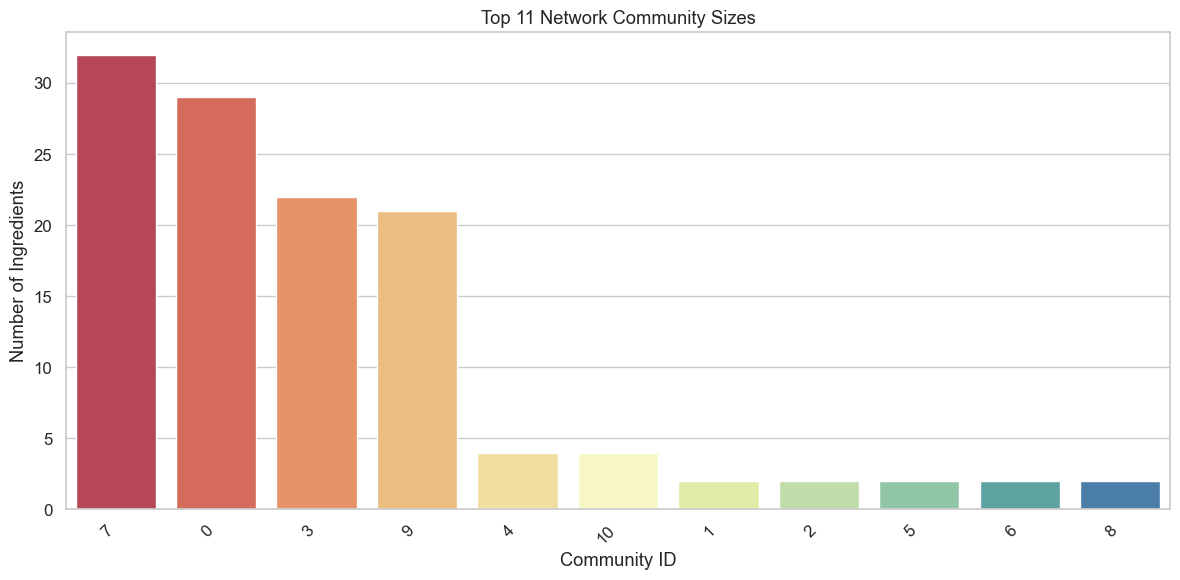


Top ingredients for the largest ~5-10 communities:
  Community 7 (32 nodes): 1/2 teaspoon salt, 1 teaspoon salt, 1/4 teaspoon salt, salt and pepper, 1 cup sugar, 2 tablespoons olive oil, 1 teaspoon vanilla, 1 tablespoon olive oil, 1 teaspoon vanilla extract, 1 cup water
  Community 0 (29 nodes): 2 eggs, 1 tsp. vanilla, 1 c. sugar, 1/4 tsp. salt, 1/2 c. sugar, 1 tsp. soda, 1 1/2 c. sugar, 1 c. flour, 1/2 c. milk, 1 c. water
  Community 3 (22 nodes): 1 tsp. salt, 4 eggs, 3 eggs, 2 c. sugar, 2 c. flour, 1 c. milk, 1/4 tsp. pepper, 1 c. sour cream, 1 egg, beaten, 2 tsp. vanilla
  Community 9 (21 nodes): 1/2 tsp. salt, 1 egg, 1 tsp. cinnamon, 3/4 c. sugar, 1 tsp. baking powder, 1 tsp. baking soda, 1 tbsp. sugar, 1/4 c. sugar, 1/8 tsp. pepper, 1/2 tsp. vanilla
  Community 4 (4 nodes): salt, pepper, black pepper, fresh ground black pepper
  Community 10 (4 nodes): salt and pepper to taste, 1 can cream of mushroom soup, 1 can cream of chicken soup, 1 can cream of celery soup
  Community 1 (2 

In [7]:
if network_results and isinstance(network_results, dict) and 'partition' in network_results and 'graph_summary' in network_results:
    print("\n--- 4. Ingredient Network Analysis ---")
    partition = network_results.get('partition')
    summary = network_results.get('graph_summary')
    # Frequencies *before* filtering, if saved
    freqs = network_results.get('ingredient_frequencies')

    if isinstance(partition, dict) and len(partition) > 0 and isinstance(summary, dict):
        num_communities = len(set(partition.values())) - (1 if -1 in set(partition.values()) else 0) # Exclude -1 if present
        print(f"Graph Summary: Nodes={summary.get('num_nodes', 'N/A')}, Edges={summary.get('num_edges', 'N/A')}")
        print(f"Detected {num_communities} communities (Louvain).")

        if num_communities > 0:
            # Get community sizes
            community_counts = Counter(partition.values())
            if -1 in community_counts: del community_counts[-1]

            if community_counts:
                 # --- Bar Plot of Community Sizes ---
                 top_n_communities_plot = 20 # Limit number shown in plot
                 sorted_communities = community_counts.most_common(top_n_communities_plot)
                 com_ids, com_sizes = zip(*sorted_communities)

                 plt.figure(figsize=(12, 6))
                 # Use string IDs for categorical plotting
                 sns.barplot(x=list(map(str, com_ids)), y=list(com_sizes), palette="Spectral")
                 plt.title(f'Top {len(com_ids)} Network Community Sizes')
                 plt.xlabel('Community ID')
                 plt.ylabel('Number of Ingredients')
                 # Adjust xticks if too crowded
                 if len(com_ids) > 15:
                     tick_indices = range(0, len(com_ids), max(1, len(com_ids)//15))
                     plt.xticks(ticks=tick_indices, labels=[com_ids[i] for i in tick_indices], rotation=45, ha='right')
                 else:
                    plt.xticks(rotation=45, ha='right')
                 plt.tight_layout()
                 plt.show()

                 # --- Print Top Ingredients per Top Community ---
                 print(f"\nTop ingredients for the largest ~5-10 communities:")
                 for i, (com_id, size) in enumerate(community_counts.most_common(10)): # Show more communities
                      nodes_in_com = [node for node, community in partition.items() if community == com_id]
                      # Get frequency of nodes within this community using the original frequency counter
                      top_nodes_str = "(Frequency data unavailable)"
                      if freqs:
                          com_freq_dict = {node: freqs.get(node, 0) for node in nodes_in_com}
                          # Sort nodes by frequency within the community
                          top_nodes = sorted(com_freq_dict, key=com_freq_dict.get, reverse=True)[:10] # Top 10
                          top_nodes_str = ', '.join(top_nodes)
                      else: # Fallback if frequencies weren't saved
                           top_nodes_str = ', '.join(nodes_in_com[:10]) + ('...' if len(nodes_in_com) > 10 else '')

                      print(f"  Community {com_id} ({size} nodes): {top_nodes_str}")

                 print("\nInterpretation: Shows the distribution of community sizes and the most frequent ingredients in the largest ones. These often represent core ingredient groups (e.g., baking basics, aromatics, spices).")

            else:
                 print("No communities (excluding -1) found to analyze.")
        else:
            print("No communities detected by Louvain.")
    else:
        print("Network partition or summary data not available or invalid in loaded results.")
else:
    print("Network results not loaded. Skipping community visualization.")

## 5. Clustering Results Interpretation and Visualization

Analyze the clusters found (e.g., TF-IDF/SVD or Embedding based) by examining representative texts/top terms and visualizing the cluster structure using dimensionality reduction (UMAP for embeddings, SVD for TF-IDF).

In [ ]:
# Helper to display cluster/topic textual details
def display_analysis_details(results_dict, analysis_name, metric_key, higher_is_better, result_key_primary, result_key_secondary=None):
    """Loads analysis results, finds best config, prints details, and returns best config key and details."""
    if not results_dict or not isinstance(results_dict, dict):
        print(f"\nNo results found for {analysis_name}.")
        return None, None

    print(f"\n--- Interpreting Best {analysis_name} --- ({metric_key}) ---")

    best_config_key = find_best_config(results_dict, metric_key, higher_is_better)

    if best_config_key:
        best_config_details = results_dict[best_config_key]
        best_score = best_config_details.get(metric_key, 'N/A')
        score_str = f"{best_score:.4f}" if isinstance(best_score, (float, np.number)) else str(best_score)
        print(f"Best Configuration: {best_config_key}")
        print(f"  - {metric_key.replace('_',' ').title()}: {score_str}")

        primary_items = best_config_details.get(result_key_primary)

        if primary_items and isinstance(primary_items, dict):
            num_items = len(primary_items)
            print(f"\nTop Terms / Representative Texts for {num_items} Clusters/Topics:")
            # Sort by cluster/topic index for consistent display
            sorted_indices = sorted(primary_items.keys(), key=lambda x: int(x) if str(x).isdigit() else float('inf'))

            for idx in sorted_indices:
                 items = primary_items[idx]
                 items_to_show = items[:7] if isinstance(items, list) else items # Limit printed items
                 if isinstance(items_to_show, list):
                     print_str = ', '.join(map(str, items_to_show))
                 elif isinstance(items_to_show, str):
                     print_str = items_to_show[:150] + ('...' if len(items_to_show) > 150 else '') # Limit string length
                 else:
                     print_str = str(items_to_show)

                 print(f"  Cluster/Topic {idx}: {print_str}")

                 if result_key_secondary:
                     secondary_container = best_config_details.get(result_key_secondary)
                     if secondary_container and isinstance(secondary_container, dict):
                          secondary_items = secondary_container.get(idx)
                          if secondary_items:
                              print(f"    Secondary Info ({result_key_secondary}): {secondary_items}")
            return best_config_key, best_config_details
        else:
            print(f"Could not find primary details ('{result_key_primary}') for the best configuration.")
            return best_config_key, best_config_details
    else:
        print(f"Could not determine the best configuration based on '{metric_key}'.")
        return None, None

# Helper for UMAP scatter plot
def plot_umap_scatter(umap_embedding, labels, title, palette='viridis', s=5, alpha=0.7, highlight_indices=None, highlight_label='Outliers', highlight_color='red', highlight_marker='x'):
    """Plots a 2D UMAP scatter plot with optional highlighting."""
    if umap_embedding is None or umap_embedding.shape[1] != 2:
        print(f"Cannot plot: UMAP embedding is missing or not 2D for '{title}'.")
        return

    plt.figure(figsize=(12, 9))
    valid_indices = ~pd.isna(labels) # Exclude points with NaN labels if any
    if not np.all(valid_indices):
         print(f"Warning: Found {np.sum(~valid_indices)} NaN labels. Excluding them from plot '{title}'.")

    scatter = sns.scatterplot(
        x=umap_embedding[valid_indices, 0],
        y=umap_embedding[valid_indices, 1],
        hue=labels[valid_indices],
        palette=palette,
        s=s,
        alpha=alpha,
        legend='full'
    )

    # Prepare legend items
    handles, existing_labels = scatter.get_legend_handles_labels()
    legend_title = 'Clusters'

    # Highlight outliers if provided
    if highlight_indices is not None and len(highlight_indices) > 0:
        # Ensure highlight indices are within bounds of the embedding
        valid_highlight_indices = highlight_indices[highlight_indices < len(umap_embedding)]
        if len(valid_highlight_indices) != len(highlight_indices):
            print(f"Warning: Filtered {len(highlight_indices) - len(valid_highlight_indices)} highlight indices out of bounds.")

        if len(valid_highlight_indices) > 0:
             plt.scatter(
                 umap_embedding[valid_highlight_indices, 0],
                 umap_embedding[valid_highlight_indices, 1],
                 marker=highlight_marker,
                 color=highlight_color,
                 s=60, # Make highlights more visible
                 label=highlight_label,
                 alpha=0.9,
                 zorder=3 # Ensure highlights are plotted on top
             )
             # Add highlight label to legend manually if needed
             if highlight_label not in existing_labels:
                 from matplotlib.lines import Line2D
                 highlight_handle = Line2D([0], [0], marker=highlight_marker, color='w', label=highlight_label, markerfacecolor=highlight_color, markersize=10, linestyle='None')
                 handles.append(highlight_handle)
                 existing_labels.append(highlight_label)
                 legend_title = 'Clusters / Highlights'

    # Place legend outside the plot
    plt.legend(handles=handles, labels=existing_labels, title=legend_title, bbox_to_anchor=(1.03, 1), loc='upper left')

    plt.title(title, fontsize=16)
    plt.xlabel("UMAP Dimension 1", fontsize=12)
    plt.ylabel("UMAP Dimension 2", fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

2025-04-16 13:02:19,036 - INFO - Best configuration found for 'silhouette_score': (12, 1000, 5, 0.85, 50) (Score: 0.1164)
2025-04-16 13:02:19,044 - INFO - Vectorizing text using TF-IDF (max_features=1000, min_df=5, max_df=0.85)...



--- Interpreting Best K-Means (TF-IDF/SVD) Clustering --- (silhouette_score) ---
Best Configuration: (12, 1000, 5, 0.85, 50)
  - Silhouette Score: 0.1164

Top Terms / Representative Texts for 12 Clusters/Topics:
  Cluster/Topic 0: olive, garlic, clove, red, black, onion, vinegar
  Cluster/Topic 1: onion, tomato, beef, bean, green, garlic, chili
  Cluster/Topic 2: whip, pineapple, cool, crush, cream, instant, strawberry
  Cluster/Topic 3: chocolate, chip, vanilla, sweet, semi, peanut, milk
  Cluster/Topic 4: cinnamon, soda, brown, nutmeg, apple, raisin, powder
  Cluster/Topic 5: vanilla, milk, extract, powder, soda, cocoa, cream
  Cluster/Topic 6: milk, salt, powder, sugar, cream, tablespoons, corn
  Cluster/Topic 7: chicken, breast, broth, boneless, skinless, onion, garlic
  Cluster/Topic 8: soup, cream, mushroom, chicken, onion, cheese, cheddar
  Cluster/Topic 9: juice, lemon, orange, lime, pineapple, grate, apple
  Cluster/Topic 10: tbsp, milk, onion, vinegar, margarine, powder, cre

2025-04-16 13:02:19,586 - INFO - TF-IDF matrix shape: (50000, 1000)
2025-04-16 13:02:19,691 - INFO - Reducing dimensions using Truncated SVD (n_components=50)...
2025-04-16 13:02:21,706 - INFO - SVD embedding shape: (50000, 50) (Took 2.01s)
2025-04-16 13:02:21,707 - INFO - SVD explained variance ratio (top 50): 0.3046
2025-04-16 13:02:21,707 - INFO - Performing KMeans clustering (k=12)...
2025-04-16 13:02:22,079 - INFO - KMeans clustering took 0.37 seconds.
2025-04-16 13:02:22,080 - INFO - Best configuration found for 'silhouette_score': (5, 30, 0.1, 5) (Score: 0.5772)
2025-04-16 13:02:22,081 - INFO - Reducing dimensions using UMAP (n_neighbors=30, min_dist=0.1, n_components=5, metric=cosine)...
C:\Users\Brian Hayward\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings

   Added 'cluster_tfidf' labels to DataFrame (k=12).

--- Interpreting Best K-Means (Embeddings) Clustering --- (silhouette_score) ---
Best Configuration: (5, 30, 0.1, 5)
  - Silhouette Score: 0.5772

Top Terms / Representative Texts for 5 Clusters/Topics:
  Cluster/Topic 0: 1 lb imitation crabmeat, chopped 1 onion, chopped 1 garlic clove, minced 14 cup margarine 14 cup flour 1 (13 1/2 ounce) can coconut milk 1 34 cups milk 1 tablespoon curry powder (or more, to taste) 1 tablespoon chicken bouillon 14 cup lemon juice rice soy sauce, 2 tablespoons butter or margarine 1 cup uncooked long-grain rice 1 cup chopped onion 1 apple, peeled and chopped 1 tablespoon curry powder 1 teaspoon minced garlic 1 (10 1/2-ounce) can condensed chicken broth, undiluted 1 bay leaf Condiments: toasted slivered almonds, toasted coconut, golden raisins, sliced green onions, apple slices, 2 (8-ounce) boneless, skinless chicken breasts 1 medium yellow onion, quartered 2 bay leaves 10 whole black peppercorns 2 te

2025-04-16 13:03:35,317 - INFO - UMAP embedding shape: (50000, 5) (Took 73.24s)
2025-04-16 13:03:35,318 - INFO - Performing KMeans clustering (k=5)...
2025-04-16 13:03:35,349 - INFO - KMeans clustering took 0.03 seconds.
C:\Users\Brian Hayward\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Brian Hayward\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   Added 'cluster_embedding' labels to DataFrame (k=5).

   Generating 2D UMAP for Ingredient Embeddings visualization...
   Generated 2D UMAP embedding for visualization (Shape: (50000, 2))


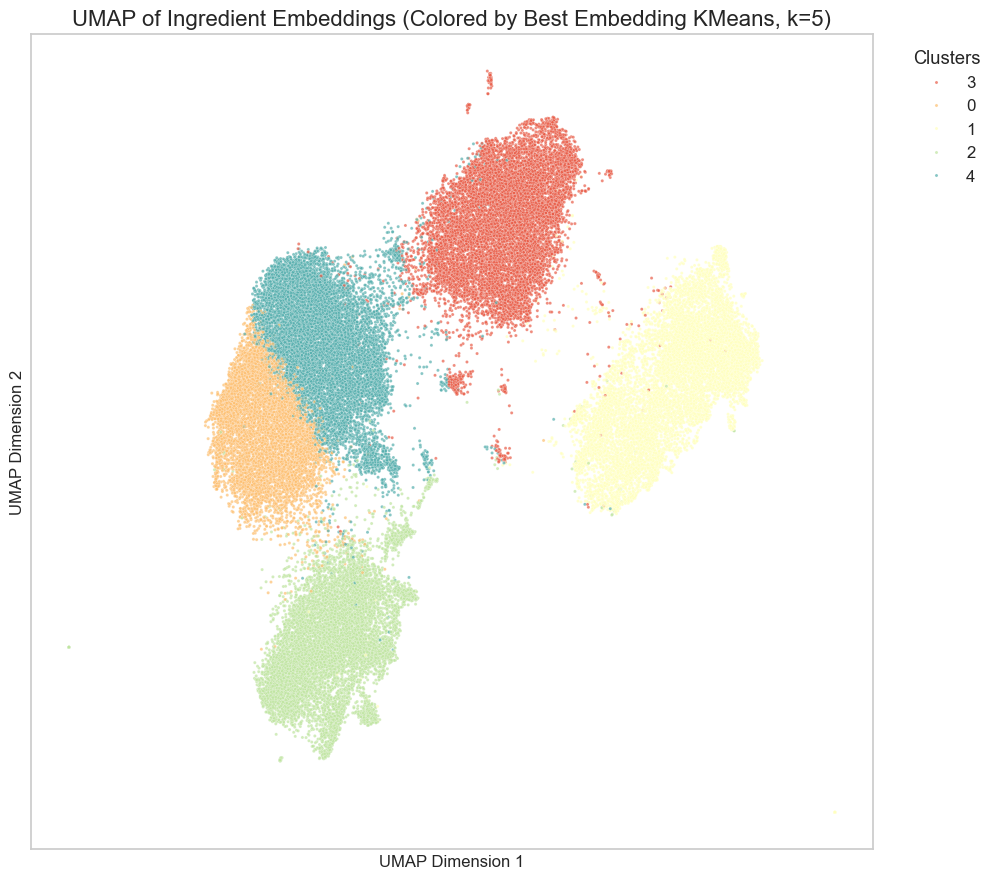

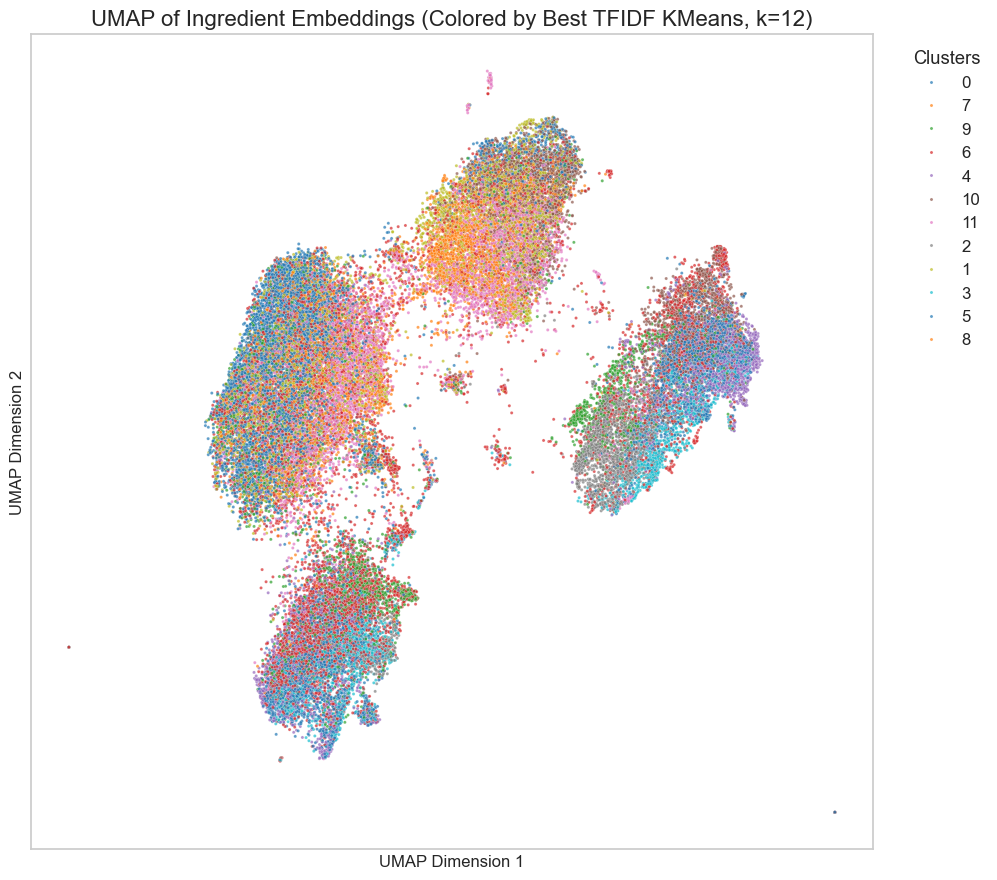


Interpretation: Coloring the semantic embedding space (UMAP) with TF-IDF cluster labels often shows poor separation, visually confirming the lower silhouette scores and semantic limitations of TF-IDF compared to embedding-based clustering.

   Generating 2D SVD for TF-IDF visualization...
   Using first 2 components from previously calculated SVD.
   Generated 2D SVD embedding for TF-IDF visualization (Shape: (50000, 2))


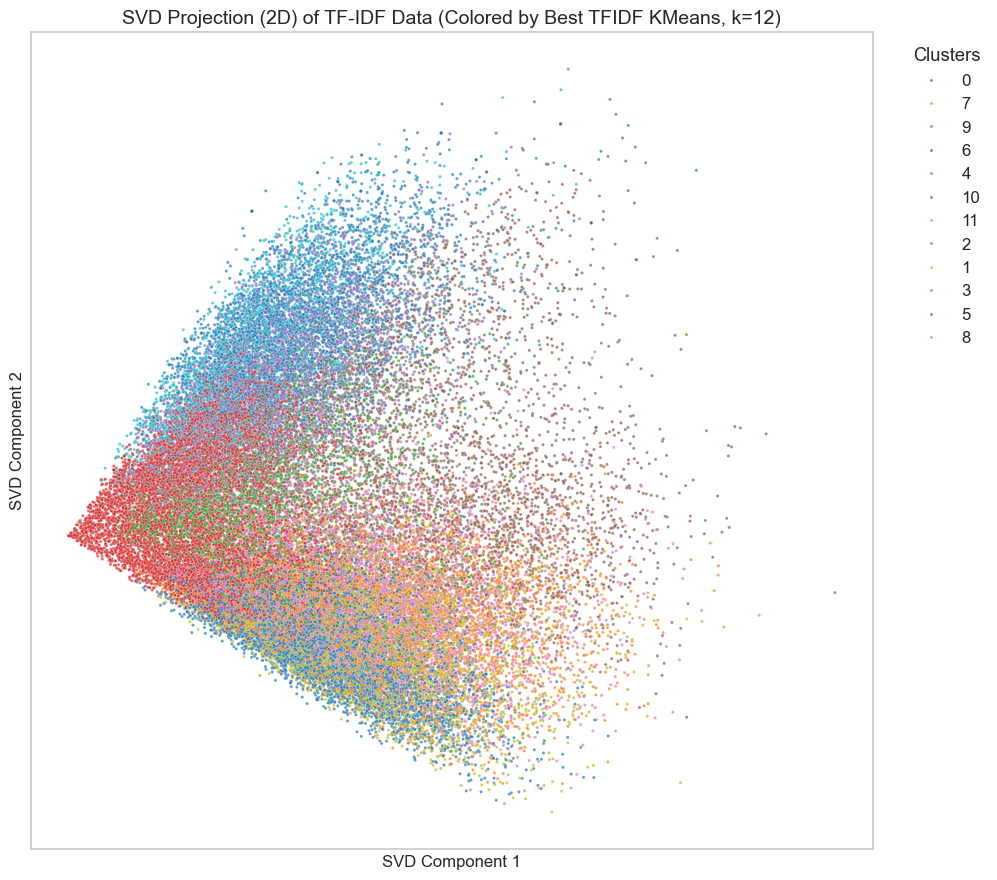

2025-04-16 13:04:14,358 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\Brian Hayward\AppData\Local\Temp\ipykernel_42308\2027751527.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_analysis, x='cluster_embedding', y=col, palette='Spectral')
2025-04-16 13:04:14,396 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-16 13:04:14,491 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before


Interpretation: This plot shows how the TF-IDF K-Means clusters appear in the first two SVD dimensions. Clusters might look more separated here than when projected onto the UMAP embedding space, as K-Means was optimized on SVD components.

   Plotting Feature Distributions per Embedding Cluster...


2025-04-16 13:04:14,614 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\Brian Hayward\AppData\Local\Temp\ipykernel_42308\2027751527.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_analysis, x='cluster_embedding', y=col, palette='Spectral')
2025-04-16 13:04:14,648 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


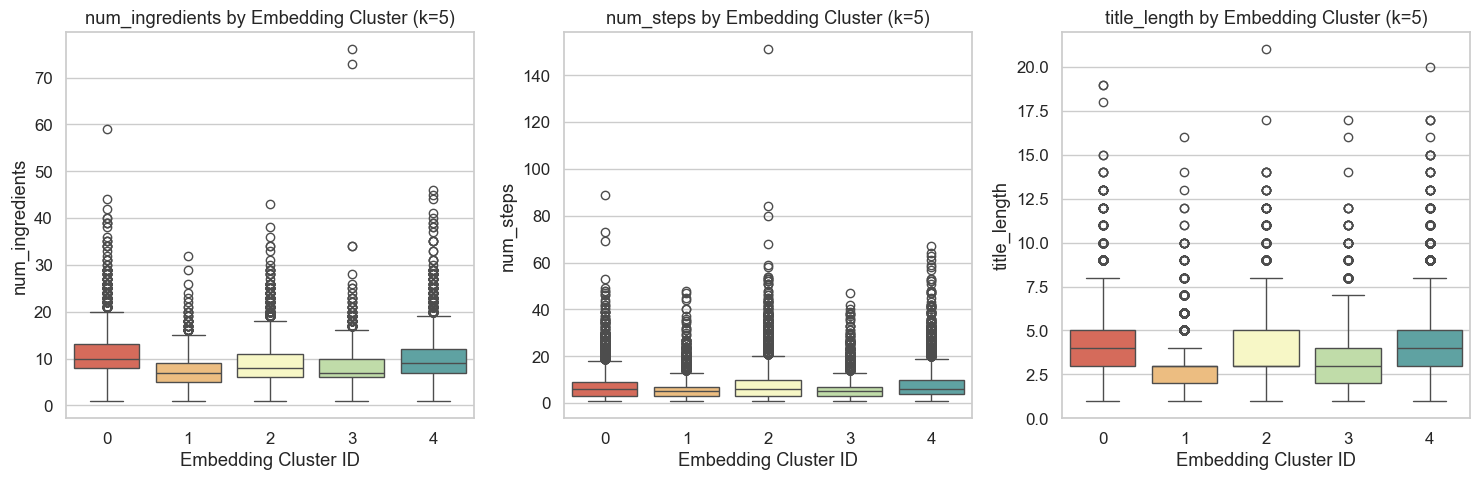

2025-04-16 13:04:14,979 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\Brian Hayward\AppData\Local\Temp\ipykernel_42308\2027751527.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_analysis, x='cluster_tfidf', y=col, palette='tab10')
2025-04-16 13:04:15,009 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-16 13:04:15,138 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotti

Interpretation: Analyze if clusters identified via embeddings differ significantly in terms of recipe length/complexity.

   Plotting Feature Distributions per TF-IDF Cluster...


C:\Users\Brian Hayward\AppData\Local\Temp\ipykernel_42308\2027751527.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_analysis, x='cluster_tfidf', y=col, palette='tab10')
2025-04-16 13:04:15,169 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-16 13:04:15,300 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\Brian Hayward\AppData\Local\Temp\ipykernel_42308\2027751527.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

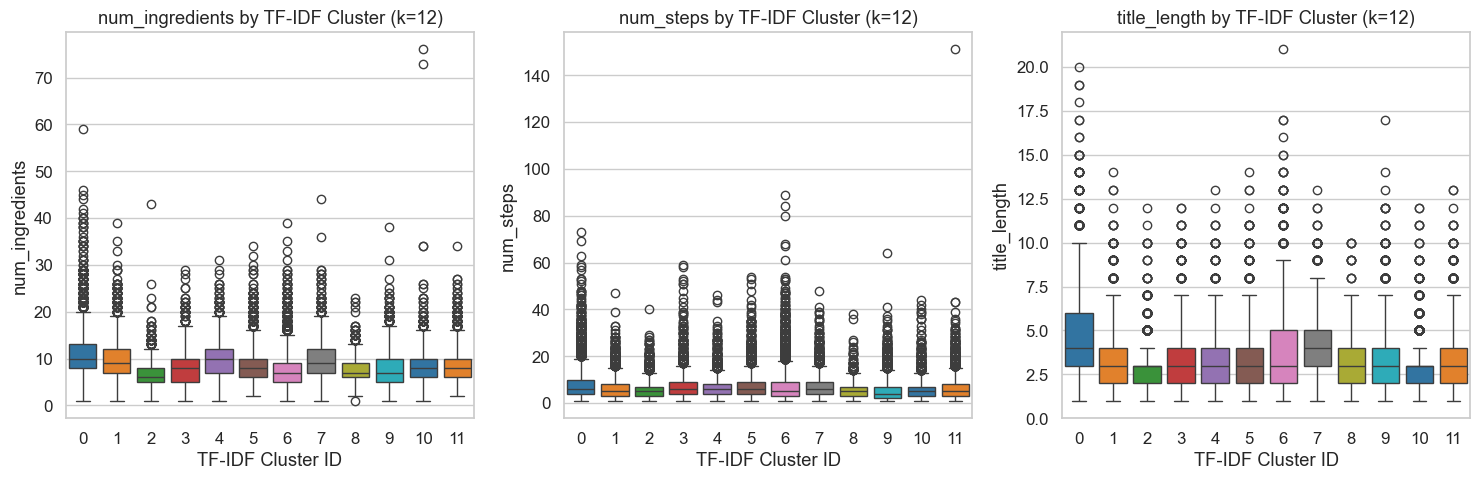

Interpretation: Compare these distributions to the embedding cluster distributions. TF-IDF clusters might show less clear patterns in these features if they primarily capture lexical similarity rather than complexity.


In [9]:
best_kmeans_tfidf_key, best_kmeans_tfidf_details = None, None
best_kmeans_emb_key, best_kmeans_emb_details = None, None
labels_tfidf = None
labels_embedding = None
umap_embedding_vis = None # For visualizing ingredient embeddings

if all_results and CONFIG_LOADED and df_analysis is not None:
    # --- 5a. Interpret Best K-Means TF-IDF/SVD Clusters --- (Textual)
    if 'kmeans_ablation_tfidf' in all_results:
        best_kmeans_tfidf_key, best_kmeans_tfidf_details = display_analysis_details(
            all_results['kmeans_ablation_tfidf'],
            "K-Means (TF-IDF/SVD) Clustering",
            metric_key='silhouette_score',
            higher_is_better=True,
            result_key_primary='top_terms' # Show top terms for TF-IDF
        )
        # Regenerate labels for the best TF-IDF model for plotting
        if best_kmeans_tfidf_details and CLUSTER_TEXT_COLUMN_SPACY_STR in df_analysis.columns:
            print("   Re-generating labels for best TF-IDF/SVD model...")
            try:
                texts_tfidf = df_analysis[CLUSTER_TEXT_COLUMN_SPACY_STR].fillna('').astype(str)
                vectorizer_best, tfidf_matrix_best = vectorize_text_tfidf(
                    texts_tfidf, best_kmeans_tfidf_details['max_features'],
                    best_kmeans_tfidf_details['min_df'], best_kmeans_tfidf_details['max_df']
                )
                if tfidf_matrix_best is not None:
                    svd_model_best, svd_embedding_best = reduce_dimensions_svd(
                        tfidf_matrix_best, best_kmeans_tfidf_details['n_components'], RANDOM_STATE
                    )
                    data_for_kmeans_tfidf = svd_embedding_best if svd_embedding_best is not None else tfidf_matrix_best
                    if data_for_kmeans_tfidf is not None:
                        kmeans_model_tfidf, labels_tfidf = perform_kmeans(
                            data_for_kmeans_tfidf, best_kmeans_tfidf_details['k'], RANDOM_STATE
                        )
                        if labels_tfidf is not None:
                            df_analysis['cluster_tfidf'] = labels_tfidf
                            print(f"   Added 'cluster_tfidf' labels to DataFrame (k={best_kmeans_tfidf_details['k']}).")
                        else: print("   KMeans failed during label regeneration.")
                    else: print("   Data prep (SVD/TFIDF) failed during label regeneration.")
                else: print("   TF-IDF vectorization failed during label regeneration.")
            except Exception as e:
                print(f"   Error re-generating TF-IDF labels: {e}")
    else:
        print("\nKMeans TF-IDF/SVD results not found in loaded data.")

    # --- 5b. Interpret Best K-Means Embedding Clusters --- (Textual)
    if 'kmeans_ablation_embeddings' in all_results:
         best_kmeans_emb_key, best_kmeans_emb_details = display_analysis_details(
            all_results['kmeans_ablation_embeddings'],
            "K-Means (Embeddings) Clustering",
            metric_key='silhouette_score',
            higher_is_better=True,
            result_key_primary='representative_texts' # Show representative texts for embeddings
        )
        # Regenerate labels for the best Embedding model for plotting
         if best_kmeans_emb_details and ingredient_embeddings is not None:
            print("   Re-generating labels for best Embedding model...")
            try:
                data_for_kmeans_emb = ingredient_embeddings
                if best_kmeans_emb_details.get('use_umap', False):
                    umap_model_best, umap_embedding_best = reduce_dimensions_umap(
                        ingredient_embeddings,
                        n_neighbors=best_kmeans_emb_details['umap_n_neighbors'],
                        min_dist=best_kmeans_emb_details['umap_min_dist'],
                        n_components=best_kmeans_emb_details['umap_n_components'],
                        metric=best_kmeans_emb_details['umap_metric'],
                        random_state=RANDOM_STATE
                    )
                    if umap_embedding_best is None:
                         print("   UMAP failed during label regeneration.")
                         data_for_kmeans_emb = None
                    else:
                        data_for_kmeans_emb = umap_embedding_best

                if data_for_kmeans_emb is not None:
                    kmeans_model_emb, labels_embedding = perform_kmeans(
                        data_for_kmeans_emb, best_kmeans_emb_details['k'], RANDOM_STATE
                    )
                    if labels_embedding is not None:
                        df_analysis['cluster_embedding'] = labels_embedding
                        print(f"   Added 'cluster_embedding' labels to DataFrame (k={best_kmeans_emb_details['k']}).")
                    else: print("   KMeans failed during label regeneration.")
            except Exception as e:
                print(f"   Error re-generating embedding labels: {e}")
    else:
         print("\nKMeans Embedding results not found in loaded data.")

    # --- 5c. UMAP Visualization of Ingredient Embeddings --- (Visual)
    if ingredient_embeddings is not None:
        print("\n   Generating 2D UMAP for Ingredient Embeddings visualization...")
        try:
            umap_reducer_vis = umap.UMAP(
                n_components=VIS_N_COMPONENTS_UMAP,
                n_neighbors=VIS_UMAP_N_NEIGHBORS,
                min_dist=VIS_UMAP_MIN_DIST,
                metric=VIS_UMAP_METRIC,
                random_state=RANDOM_STATE,
                verbose=False
            )
            umap_embedding_vis = umap_reducer_vis.fit_transform(ingredient_embeddings)
            print(f"   Generated 2D UMAP embedding for visualization (Shape: {umap_embedding_vis.shape})")

            # Plot UMAP colored by best Embedding K-Means clusters
            if 'cluster_embedding' in df_analysis.columns and best_kmeans_emb_details:
                plot_umap_scatter(
                    umap_embedding_vis,
                    labels=df_analysis['cluster_embedding'].astype(str), # Use string labels for discrete palette
                    title=f'UMAP of Ingredient Embeddings (Colored by Best Embedding KMeans, k={best_kmeans_emb_details["k"]})',
                    palette='Spectral' # Choose a nice palette
                )
            else:
                print("   Skipping UMAP plot (Embedding Clusters): Labels not generated or best config missing.")

            # Plot UMAP colored by best TF-IDF K-Means clusters (if available)
            if 'cluster_tfidf' in df_analysis.columns and best_kmeans_tfidf_details:
                 plot_umap_scatter(
                     umap_embedding_vis,
                     labels=df_analysis['cluster_tfidf'].astype(str),
                     title=f'UMAP of Ingredient Embeddings (Colored by Best TFIDF KMeans, k={best_kmeans_tfidf_details["k"]})',
                     palette='tab10' # Use a different palette for comparison
                 )
                 print("\nInterpretation: Coloring the semantic embedding space (UMAP) with TF-IDF cluster labels often shows poor separation, visually confirming the lower silhouette scores and semantic limitations of TF-IDF compared to embedding-based clustering.")
            else:
                 print("   Skipping UMAP plot (TFIDF Clusters): Labels not generated or best config missing.")

        except Exception as e:
            print(f"   Error during UMAP visualization generation: {e}")
            umap_embedding_vis = None
    else:
        print("Skipping UMAP visualization: Ingredient embeddings not available.")

    # --- 5d. Visualize TF-IDF/SVD Space --- (Visual)
    if best_kmeans_tfidf_details and 'cluster_tfidf' in df_analysis.columns:
        print("\n   Generating 2D SVD for TF-IDF visualization...")
        try:
            # Reuse previously generated TF-IDF matrix and SVD model if available
            # Otherwise, regenerate specifically for 2D viz
            if 'svd_embedding_best' in locals() and svd_embedding_best is not None and svd_embedding_best.shape[1] >= 2:
                svd_embedding_vis = svd_embedding_best[:, :2]
                print("   Using first 2 components from previously calculated SVD.")
            elif 'tfidf_matrix_best' in locals() and tfidf_matrix_best is not None:
                 print("   Running SVD specifically for 2D visualization...")
                 svd_model_vis, svd_embedding_vis = reduce_dimensions_svd(
                     tfidf_matrix_best, n_components=2, random_state=RANDOM_STATE
                 )
            else:
                 print("   TF-IDF matrix not available, cannot generate SVD plot.")
                 svd_embedding_vis = None

            if svd_embedding_vis is not None and svd_embedding_vis.shape[1] == 2:
                print(f"   Generated 2D SVD embedding for TF-IDF visualization (Shape: {svd_embedding_vis.shape})")

                plt.figure(figsize=(12, 9))
                scatter_svd = sns.scatterplot(
                    x=svd_embedding_vis[:, 0],
                    y=svd_embedding_vis[:, 1],
                    hue=df_analysis['cluster_tfidf'].astype(str),
                    palette='tab10',
                    s=5,
                    alpha=0.7,
                    legend='full'
                )
                plt.legend(title='Clusters', bbox_to_anchor=(1.03, 1), loc='upper left')
                plt.title(f'SVD Projection (2D) of TF-IDF Data (Colored by Best TFIDF KMeans, k={best_kmeans_tfidf_details["k"]})', fontsize=14)
                plt.xlabel("SVD Component 1", fontsize=12)
                plt.ylabel("SVD Component 2", fontsize=12)
                plt.xticks([])
                plt.yticks([])
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.tight_layout(rect=[0, 0, 0.85, 1])
                plt.show()

                print("\nInterpretation: This plot shows how the TF-IDF K-Means clusters appear in the first two SVD dimensions. Clusters might look more separated here than when projected onto the UMAP embedding space, as K-Means was optimized on SVD components.")

            else:
                print("   Failed to generate 2D SVD embedding for TF-IDF.")
        except Exception as e:
            print(f"   Error during SVD visualization generation: {e}")
    else:
        print("Skipping TF-IDF/SVD visualization: Best TF-IDF model/labels not available.")

    # --- 5e. Feature Distributions per Cluster --- (Visual)
    existing_eda_cols = [col for col in ['num_ingredients', 'num_steps', 'title_length'] if col in df_analysis.columns]
    if existing_eda_cols:
        if 'cluster_embedding' in df_analysis.columns and best_kmeans_emb_details:
            print("\n   Plotting Feature Distributions per Embedding Cluster...")
            plt.figure(figsize=(15, 5))
            for i, col in enumerate(existing_eda_cols):
                plt.subplot(1, len(existing_eda_cols), i + 1)
                sns.boxplot(data=df_analysis, x='cluster_embedding', y=col, palette='Spectral')
                plt.title(f'{col} by Embedding Cluster (k={best_kmeans_emb_details["k"]})')
                plt.xlabel('Embedding Cluster ID')
            plt.tight_layout()
            plt.show()
            print("Interpretation: Analyze if clusters identified via embeddings differ significantly in terms of recipe length/complexity.")

        if 'cluster_tfidf' in df_analysis.columns and best_kmeans_tfidf_details:
            print("\n   Plotting Feature Distributions per TF-IDF Cluster...")
            plt.figure(figsize=(15, 5))
            for i, col in enumerate(existing_eda_cols):
                plt.subplot(1, len(existing_eda_cols), i + 1)
                sns.boxplot(data=df_analysis, x='cluster_tfidf', y=col, palette='tab10')
                plt.title(f'{col} by TF-IDF Cluster (k={best_kmeans_tfidf_details["k"]})')
                plt.xlabel('TF-IDF Cluster ID')
            plt.tight_layout()
            plt.show()
            print("Interpretation: Compare these distributions to the embedding cluster distributions. TF-IDF clusters might show less clear patterns in these features if they primarily capture lexical similarity rather than complexity.")
else:
    print("Clustering analysis skipped: Config, DataFrame, or Results not loaded.")


## 6. Topic Modeling Results Interpretation (LDA)

2025-04-16 13:04:15,748 - INFO - Best configuration found for 'coherence_c_v': (12, 1000, 5, 0.85) (Score: 0.5902)



--- 6. LDA Topic Modeling Interpretation ---

--- Interpreting Best LDA Topic Modeling (CountVectorizer) --- (coherence_c_v) ---
Best Configuration: (12, 1000, 5, 0.85)
  - Coherence C V: 0.5902

Top Terms / Representative Texts for 12 Clusters/Topics:
  Cluster/Topic 0: mixture, cream, stir, milk, chocolate, pie, cool
  Cluster/Topic 1: bread, spray, pork, cooking, slice, chop, coat
  Cluster/Topic 2: potato, tender, orange, stir, boil, cover, bring
  Cluster/Topic 3: add, bake, mix, cookie, mixture, cream, vanilla
  Cluster/Topic 4: place, slice, foil, cut, line, edge, paper
  Cluster/Topic 5: add, tomato, olive, garlic, toss, onion, pasta
  Cluster/Topic 6: chicken, grill, place, meat, fish, towel, remove
  Cluster/Topic 7: juice, lemon, serve, ice, chill, add, cream
  Cluster/Topic 8: cheese, onion, bake, mixture, brown, add, mix
  Cluster/Topic 9: dough, roll, ball, apple, place, dressing, brown
  Cluster/Topic 10: cake, batter, mixer, speed, come, clean, muffin
  Cluster/Topic 1

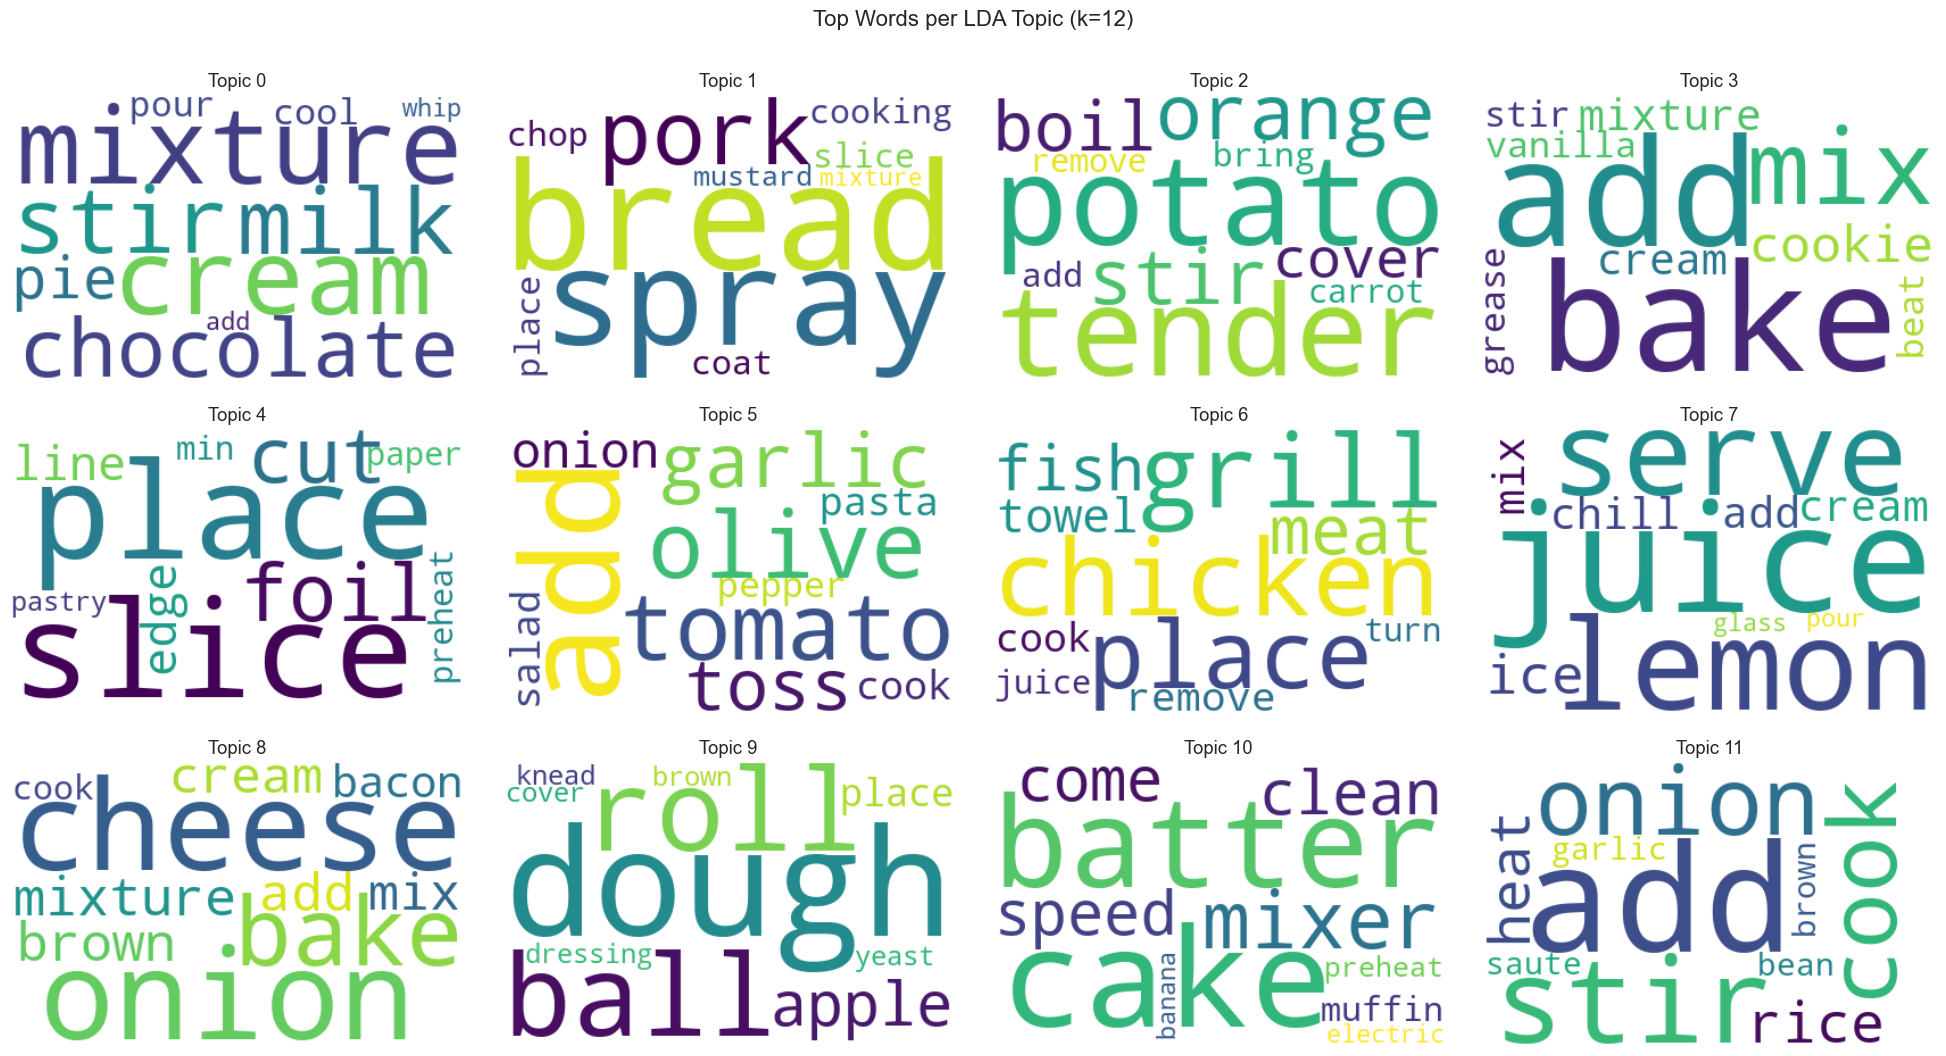

Interpretation: These word clouds visually represent the themes captured by each topic, often corresponding to different cooking actions, ingredient types, or cuisine styles found in the directions.


In [10]:
best_lda_key, best_lda_details = None, None
if all_results and CONFIG_LOADED:
    print("\n--- 6. LDA Topic Modeling Interpretation ---")
    if 'lda_ablation_countvec' in all_results:
        coherence_metric = f'coherence_{LDA_TRAD_COHERENCE_MEASURE}'
        best_lda_key, best_lda_details = display_analysis_details(
            all_results['lda_ablation_countvec'],
            "LDA Topic Modeling (CountVectorizer)",
            metric_key=coherence_metric,
            higher_is_better=True,
            result_key_primary='top_words'
        )

        # Plot Word Clouds for each topic of the best LDA model
        if best_lda_details:
            top_words_dict = best_lda_details.get('top_words', {})
            if top_words_dict:
                print("\n   Generating LDA Topic Word Clouds...")
                n_topics = best_lda_details['n_topics']
                # Determine grid size (e.g., 4 columns wide)
                ncols = 4
                nrows = (n_topics + ncols - 1) // ncols
                plt.figure(figsize=(ncols * 5, nrows * 3.5))

                sorted_topic_indices = sorted(top_words_dict.keys(), key=lambda x: int(x) if str(x).isdigit() else float('inf'))

                for i, topic_idx in enumerate(sorted_topic_indices):
                    if topic_idx >= n_topics: continue # Safety
                    words = top_words_dict[topic_idx]
                    plt.subplot(nrows, ncols, i + 1)
                    # Create word frequencies for word cloud (can weight top words more)
                    word_freq = {word: 1 for word in words}
                    try:
                         wordcloud = WordCloud(width=400, height=250, background_color='white', colormap='viridis').generate_from_frequencies(word_freq)
                         plt.imshow(wordcloud, interpolation='bilinear')
                    except Exception as wc_error:
                         print(f"     Error generating wordcloud for topic {topic_idx}: {wc_error}")
                         plt.text(0.5, 0.5, f'Topic {topic_idx}\n(Error)', ha='center', va='center')

                    plt.axis('off')
                    plt.title(f'Topic {topic_idx}')

                plt.tight_layout(pad=2.0)
                plt.suptitle(f'Top Words per LDA Topic (k={n_topics})', fontsize=16, y=1.03)
                plt.show()
                print("Interpretation: These word clouds visually represent the themes captured by each topic, often corresponding to different cooking actions, ingredient types, or cuisine styles found in the directions.")
            else:
                print("   Skipping LDA word clouds: Top words not found in best LDA results.")
    else:
        print("LDA results (lda_ablation_countvec) not found in loaded data.")
else:
    print("LDA analysis skipped: Config or Results not loaded.")

## 7. Stability and Outlier Analysis Results


--- 7a. Stability Analysis Summary ---
KMeans (TF-IDF/SVD) Stability:
  - Best Config Tested: (12, 1000, 5, 0.85, 50)
  - Average ARI across runs: 0.7272

KMeans (Embedding) Stability:
  - Best Config Tested: (5, 30, 0.1, 5)
  - Average ARI across runs: 0.8106

LDA Stability:
  - Best Config Tested: (12, 1000, 5, 0.85)
  - Mean Coherence (c_v) across runs: 0.5829
  - Std Dev Coherence across runs: 0.0131

--- 7b. Outlier Analysis Summary & Visualization ---

Kmeans Tfidf Outliers Summary:
  Found 10 outliers.
  Top ~5 Examples (Sorted by outlier score - Higher is more outlier):
    - Orig Index 5077: Score (Distance)=1.0000 | Text: 'kettle stockpot lid fit kettle lifter ladle'
    - Orig Index 29674: Score (Distance)=1.0000 | Text: 'photograph antonis achilleos'
    - Orig Index 7490: Score (Distance)=1.0000 | Text: 'soybean'
    - Orig Index 19192: Score (Distance)=1.0000 | Text: ''
    - Orig Index 46914: Score (Distance)=1.0000 | Text: ''

Kmeans Embedding Outliers Summary:
  Found

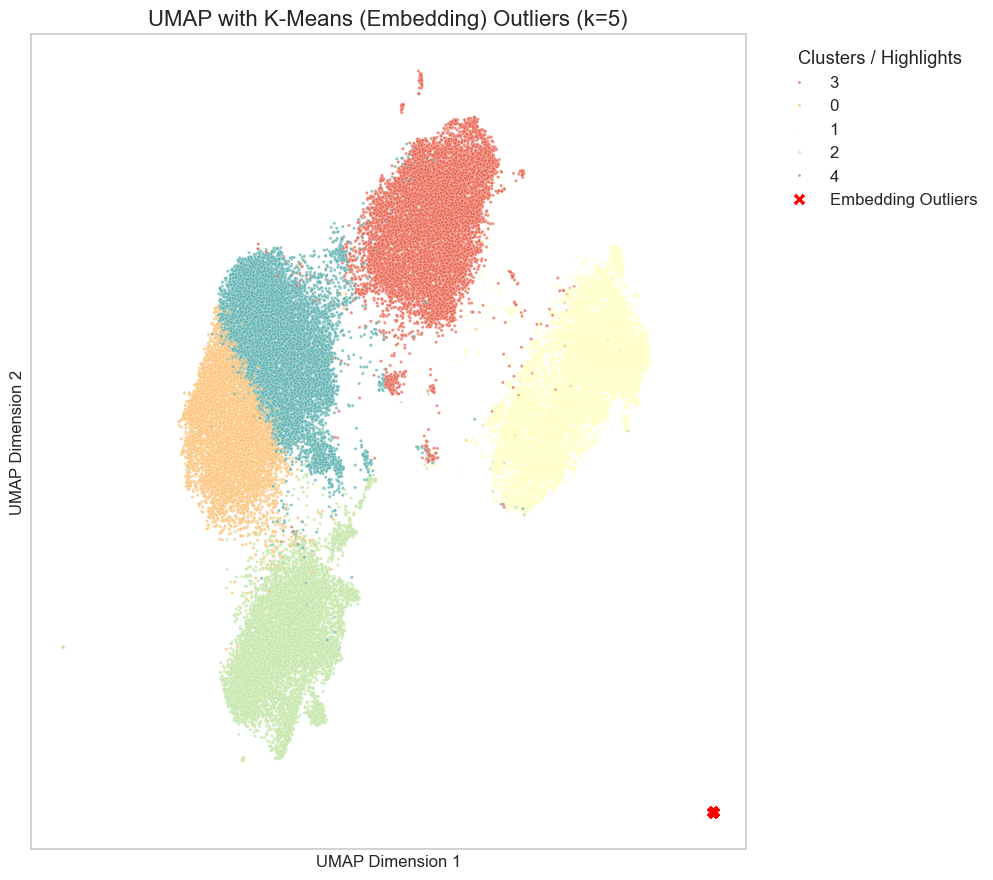

Interpretation: Embedding outliers (red X) are points potentially far from their cluster center in the semantic space. Check their text to see if they are unusual recipes.


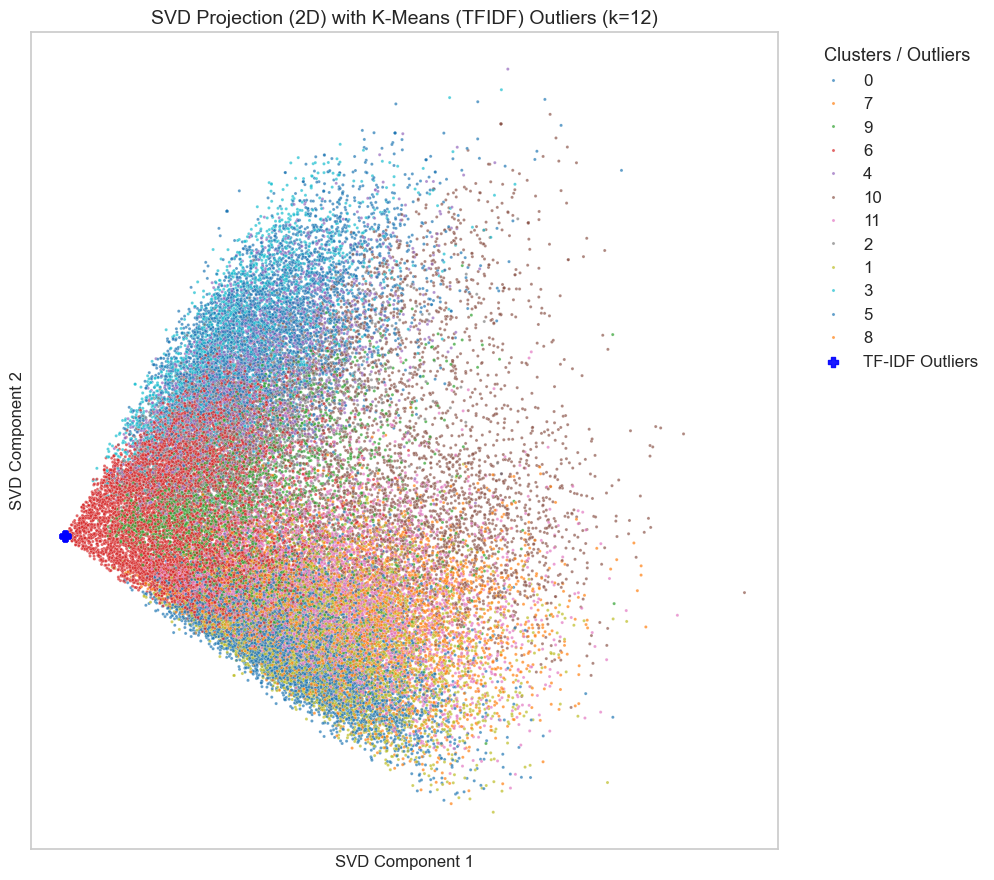

Interpretation: TF-IDF outliers (blue P) are points potentially far from their cluster center in the TF-IDF/SVD space. Compare with the embedding outliers.


In [11]:
if all_results and CONFIG_LOADED:
    # --- 7a. Stability Analysis Summary ---
    if 'stability_analysis' in all_results:
        print("\n--- 7a. Stability Analysis Summary ---")
        stability = all_results['stability_analysis']

        # KMeans TF-IDF Stability
        if 'kmeans_tfidf' in stability and stability['kmeans_tfidf']:
            s_tfidf = stability['kmeans_tfidf']
            ari = s_tfidf.get('avg_ari')
            cfg = s_tfidf.get('best_config', 'N/A')
            print(f"KMeans (TF-IDF/SVD) Stability:")
            print(f"  - Best Config Tested: {cfg}")
            print(f"  - Average ARI across runs: {ari:.4f}" if ari is not None else "  - Average ARI: N/A")
            if ari is not None and ari < 0.6: print("  - Note: Low ARI suggests clusters may not be very stable across data samples.")
        else:
            print("KMeans (TF-IDF/SVD) Stability: No results found.")

        # KMeans Embedding Stability
        if 'kmeans_embedding' in stability and stability['kmeans_embedding']:
            s_emb = stability['kmeans_embedding']
            ari = s_emb.get('avg_ari')
            cfg = s_emb.get('best_config', 'N/A')
            print(f"\nKMeans (Embedding) Stability:")
            print(f"  - Best Config Tested: {cfg}")
            print(f"  - Average ARI across runs: {ari:.4f}" if ari is not None else "  - Average ARI: N/A")
            if ari is not None and ari < 0.6: print("  - Note: Low ARI suggests clusters may not be very stable across data samples.")
        else:
            print("\nKMeans (Embedding) Stability: No results found.")

        # LDA Stability
        if 'lda' in stability and stability['lda']:
            s_lda = stability['lda']
            # Dynamically find coherence keys
            metric_name = next((k for k in s_lda if k.startswith('mean_coherence')), None)
            std_metric_name = next((k for k in s_lda if k.startswith('std_coherence')), None)
            mean_coh = s_lda.get(metric_name)
            std_coh = s_lda.get(std_metric_name)
            cfg = s_lda.get('best_config', 'N/A')
            coh_measure = metric_name.split('mean_coherence_')[-1] if metric_name else LDA_TRAD_COHERENCE_MEASURE
            print(f"\nLDA Stability:")
            print(f"  - Best Config Tested: {cfg}")
            print(f"  - Mean Coherence ({coh_measure}) across runs: {mean_coh:.4f}" if mean_coh is not None else "  - Mean Coherence: N/A")
            print(f"  - Std Dev Coherence across runs: {std_coh:.4f}" if std_coh is not None else "  - Std Dev Coherence: N/A")
            if std_coh is not None and std_coh > 0.05: print("  - Note: High standard deviation suggests topic coherence varied significantly across runs.")
        else:
            print("\nLDA Stability: No results found.")

    else:
        print("\nStability analysis results not found in loaded data.")

    # --- 7b. Outlier Analysis Summary & Visualization ---
    if 'outlier_analysis' in all_results:
        print("\n--- 7b. Outlier Analysis Summary & Visualization ---")
        outliers = all_results['outlier_analysis']

        # Function to print outlier details
        def print_outliers_summary(outlier_data, analysis_type):
            print(f"\n{analysis_type.replace('_', ' ').title()} Outliers Summary:")
            if analysis_type in outlier_data and outlier_data[analysis_type]:
                data = outlier_data[analysis_type]
                indices = data.get('indices', [])
                texts = data.get('texts', [])
                scores = data.get('distances') or data.get('max_probabilities')
                score_label = "Distance" if 'distances' in data else "Max Probability"
                is_distance = 'distances' in data # Higher distance = more outlier; Lower prob = more outlier

                if indices and texts and scores is not None and len(indices) == len(texts) == len(scores):
                     print(f"  Found {len(indices)} outliers.")
                     # Sort by score (descending for distance, ascending for probability)
                     sort_order = np.argsort(scores)[::-1] if is_distance else np.argsort(scores)
                     print(f"  Top ~5 Examples (Sorted by outlier score - {'Higher' if is_distance else 'Lower'} is more outlier):")
                     for i in range(min(5, len(indices))):
                         idx_in_list = sort_order[i]
                         original_index = indices[idx_in_list]
                         text_snippet = texts[idx_in_list][:120] + '...' if len(texts[idx_in_list]) > 120 else texts[idx_in_list]
                         score_val = scores[idx_in_list]
                         print(f"    - Orig Index {original_index}: Score ({score_label})={score_val:.4f} | Text: '{text_snippet}'")
                else:
                     print(f"  - Outlier data incomplete or missing for {analysis_type}.")
            else:
                 print(f"  No results found for {analysis_type}.")

        # Print summaries
        print_outliers_summary(outliers, 'kmeans_tfidf')
        print_outliers_summary(outliers, 'kmeans_embedding')
        print_outliers_summary(outliers, 'lda')

        # Visualize Outliers on UMAP/SVD plots
        print("\n   Highlighting Outliers on Plots...")

        # Highlight K-Means Embedding Outliers on UMAP Plot
        outlier_indices_emb = None
        if umap_embedding_vis is not None and 'kmeans_embedding' in outliers and outliers['kmeans_embedding']:
             outliers_emb_data = outliers['kmeans_embedding']
             if 'indices' in outliers_emb_data and len(outliers_emb_data['indices']) > 0:
                 outlier_indices_emb = np.array(outliers_emb_data['indices']).astype(int)
                 # Ensure indices are valid for the embedding shape
                 outlier_indices_emb = outlier_indices_emb[outlier_indices_emb < len(umap_embedding_vis)]
                 if len(outlier_indices_emb) > 0 and 'cluster_embedding' in df_analysis.columns and best_kmeans_emb_details:
                      plot_umap_scatter(
                         umap_embedding_vis,
                         labels=df_analysis['cluster_embedding'].astype(str),
                         title=f'UMAP with K-Means (Embedding) Outliers (k={best_kmeans_emb_details["k"]})',
                         palette='Spectral',
                         highlight_indices=outlier_indices_emb,
                         highlight_label='Embedding Outliers',
                         highlight_color='red',
                         highlight_marker='X'
                      )
                      print("Interpretation: Embedding outliers (red X) are points potentially far from their cluster center in the semantic space. Check their text to see if they are unusual recipes.")
                 else:
                     print("    Skipping Embedding outlier plot: Missing necessary data (embeddings, labels, or indices)." )
             else:
                 print("    No embedding outlier indices found.")

        # Highlight K-Means TF-IDF Outliers on SVD Plot (if available)
        outlier_indices_tfidf = None
        if 'svd_embedding_vis' in locals() and svd_embedding_vis is not None and 'kmeans_tfidf' in outliers and outliers['kmeans_tfidf']:
            outliers_tfidf_data = outliers['kmeans_tfidf']
            if 'indices' in outliers_tfidf_data and len(outliers_tfidf_data['indices']) > 0:
                outlier_indices_tfidf = np.array(outliers_tfidf_data['indices']).astype(int)
                # Ensure indices are valid for the SVD embedding shape
                outlier_indices_tfidf = outlier_indices_tfidf[outlier_indices_tfidf < len(svd_embedding_vis)]
                if len(outlier_indices_tfidf) > 0 and 'cluster_tfidf' in df_analysis.columns and best_kmeans_tfidf_details:
                    # Re-plot SVD with highlights
                    plt.figure(figsize=(12, 9))
                    scatter_svd_hl = sns.scatterplot(
                        x=svd_embedding_vis[:, 0],
                        y=svd_embedding_vis[:, 1],
                        hue=df_analysis['cluster_tfidf'].astype(str),
                        palette='tab10', s=5, alpha=0.7, legend='full'
                    )
                    plt.scatter(
                         svd_embedding_vis[outlier_indices_tfidf, 0],
                         svd_embedding_vis[outlier_indices_tfidf, 1],
                         marker='P', color='blue', s=60,
                         label='TF-IDF Outliers', alpha=0.9, zorder=3
                    )
                    handles_svd, labels_svd = scatter_svd_hl.get_legend_handles_labels()
                    if 'TF-IDF Outliers' not in labels_svd:
                         from matplotlib.lines import Line2D
                         hl_handle = Line2D([0], [0], marker='P', color='w', label='TF-IDF Outliers', markerfacecolor='blue', markersize=10, linestyle='None')
                         handles_svd.append(hl_handle)
                         labels_svd.append('TF-IDF Outliers')
                    plt.legend(handles=handles_svd, labels=labels_svd, title='Clusters / Outliers', bbox_to_anchor=(1.03, 1), loc='upper left')
                    plt.title(f'SVD Projection (2D) with K-Means (TFIDF) Outliers (k={best_kmeans_tfidf_details["k"]})', fontsize=14)
                    plt.xlabel("SVD Component 1", fontsize=12)
                    plt.ylabel("SVD Component 2", fontsize=12)
                    plt.xticks([])
                    plt.yticks([])
                    plt.grid(True, linestyle='--', alpha=0.5)
                    plt.tight_layout(rect=[0, 0, 0.85, 1])
                    plt.show()
                    print("Interpretation: TF-IDF outliers (blue P) are points potentially far from their cluster center in the TF-IDF/SVD space. Compare with the embedding outliers.")
                else:
                     print("   Skipping TF-IDF outlier plot: Missing necessary data (SVD embedding, labels, or indices)." )
            else:
                print("   No TF-IDF outlier indices found.")
        else:
            print("   Skipping TF-IDF outlier plot: SVD embedding not generated or TF-IDF outliers missing.")

    else:
        print("\nOutlier analysis results not found in loaded data.")
else:
    print("Stability/Outlier analysis skipped: Config or Results not loaded.")